In [ ]:
import porespy.generators as generator
import matplotlib.pyplot as plt
import numpy as np

In [7]:
import seaborn as sns
from scipy.stats import mode, pearsonr
import pandas as pd

In [1]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [10]:
sns.set_theme()

# functions for statistics

In [4]:

def split_arr_to_zeros_and_ones_sizes(arr):
    edge_indeces = np.argwhere(~(np.diff(arr) == 0)).flatten() +1
    segments = np.split(arr, edge_indeces)

    segments_zeros = []
    segments_ones = []

    for segment in segments:
        if np.any(segment):
            segments_ones.append(len(segment))
        else:
            segments_zeros.append(len(segment))

    return segments_zeros, segments_ones


In [5]:
def get_stats(phantom, row_numbers, axis=0):
    stat_ones, stat_zeros = [], []

    if axis == 0:
        for row_num in row_numbers:
            segments_zeros, segments_ones = split_arr_to_zeros_and_ones_sizes(phantom[row_num])
            stat_zeros.append(segments_zeros)
            stat_ones.append(segments_ones)
    elif axis == 1:
        for row_num in row_numbers:
            segments_zeros, segments_ones = split_arr_to_zeros_and_ones_sizes(phantom[:, row_num])
            stat_zeros.append(segments_zeros)
            stat_ones.append(segments_ones)
    elif axis == "Both":
        for row_num in row_numbers:
            segments_zeros, segments_ones = split_arr_to_zeros_and_ones_sizes(phantom[row_num])
            stat_zeros.append(segments_zeros)
            stat_ones.append(segments_ones)

            segments_zeros, segments_ones = split_arr_to_zeros_and_ones_sizes(phantom[:, row_num])
            stat_zeros.append(segments_zeros)
            stat_ones.append(segments_ones)

    stat_ones, stat_zeros = np.concatenate(stat_ones), np.concatenate(stat_zeros)

    return stat_zeros, stat_ones 


In [6]:
def compare_stats(stats, names_of_stats, num_bins=50):
    nrows = 3
    ncols = len(stats)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 5*nrows), constrained_layout=True)

    for ax, stat, title in zip(axes[0], stats, names_of_stats):
        sns.histplot(stat, bins=num_bins, ax=ax).set_title(title+f" std: {np.std(stat):.2f}")

        mean = np.mean(stat)
        ax.axvline(mean, color='red', linewidth=3, label=f"mean: {mean:.2f}")

        mode_value = int(mode(stat)[0])
        ax.axvline(mode_value, color='purple', linewidth=2, label=f"mode: {mode_value:.2f}")
        # median = np.median(stat)
        # ax.axvline(median, color='green', linewidth=3, label=f"median: {median:.2f}")
        ax.legend()

    for ax, stat, title in zip(axes[1], stats, names_of_stats):
        sns.histplot(stat, bins=num_bins, cumulative=True, kde=True, ax=ax).set_title(f'cumulative {title}')

    for ax, stat, title in zip(axes[2], stats, names_of_stats):
        sns.histplot(stat, 
                     bins=num_bins,
                     cumulative=True,
                     kde=True,
                     stat="density",
                     ax=ax).set_title(f'cumulative density {title}')

        percetile = 90
        length_percetile = np.percentile(stat, percetile)
        ax.axhline(0.9, color='red', linewidth=3, label=f"{percetile} percetile: x={length_percetile}")
        ax.axvline(length_percetile, color='red', linewidth=3)
        ax.legend(loc=4)

    return fig

# 1 phantom

(-0.5, 999.5, 999.5, -0.5)

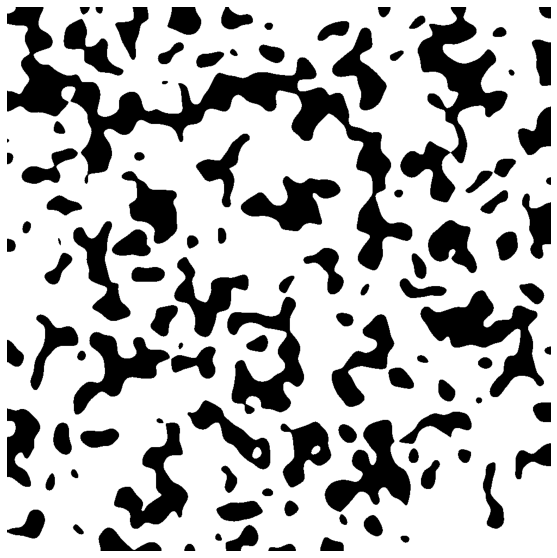

In [8]:
shape = [1000, 1000]
blobns = 2
porosity = 0.3
phantom = generator.blobs(shape, porosity= 1 - porosity, blobiness=blobns)

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(phantom, cmap='gray')
ax.axis("off")

In [9]:
phantom.size

1000000

In [9]:
axis = 1

# few random
# N = 100
# row_numbers = [np.random.randint(phantom.shape[axis]) for _ in range(N)]

# all
row_numbers = range(phantom.shape[axis])

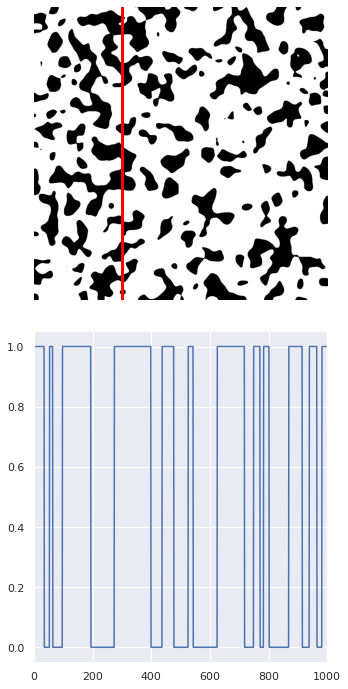

In [10]:
fig, axes = plt.subplots(nrows=2, figsize=(5,10))
num_row = 300
axes[0].imshow(phantom, cmap='gray')
axes[0].axis("off")

if axis == 0:
    axes[1].plot(phantom[num_row])
    axes[0].axhline(num_row, color='red', linewidth=3)
elif axis == 1:
    axes[1].plot(phantom[:, num_row])
    axes[0].axvline(num_row, color='red', linewidth=3)

axes[1].set_xlim(xmin=0, xmax=len(phantom[num_row]))
plt.tight_layout()

In [11]:
stat_ones, stat_zeros = get_stats(phantom, row_numbers)

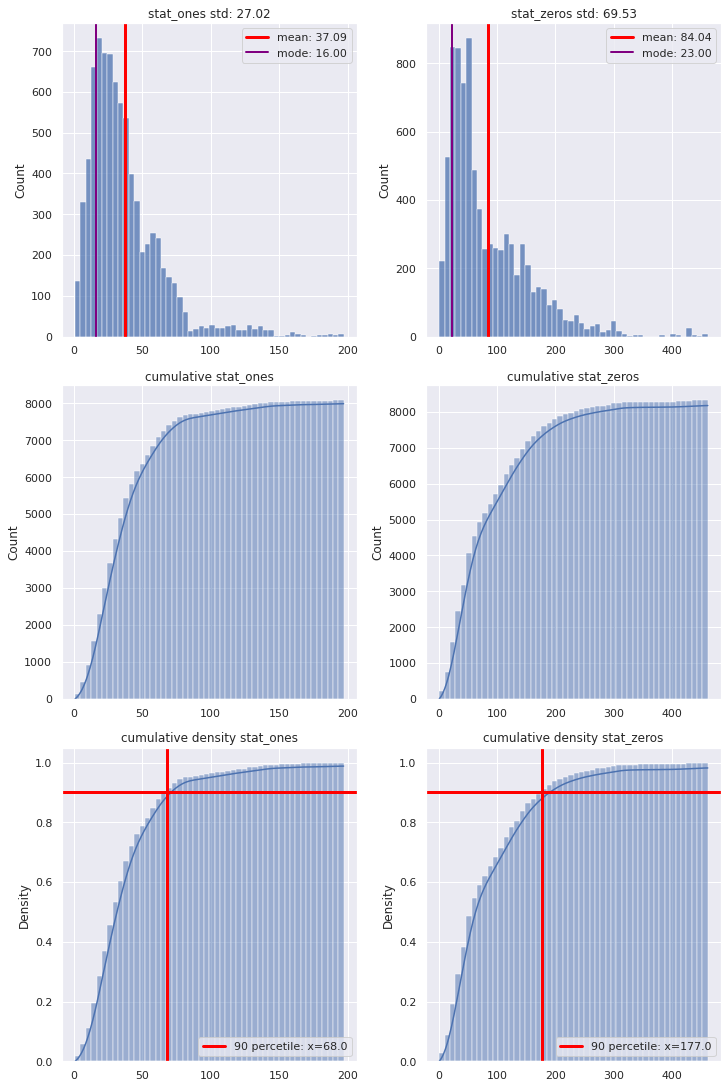

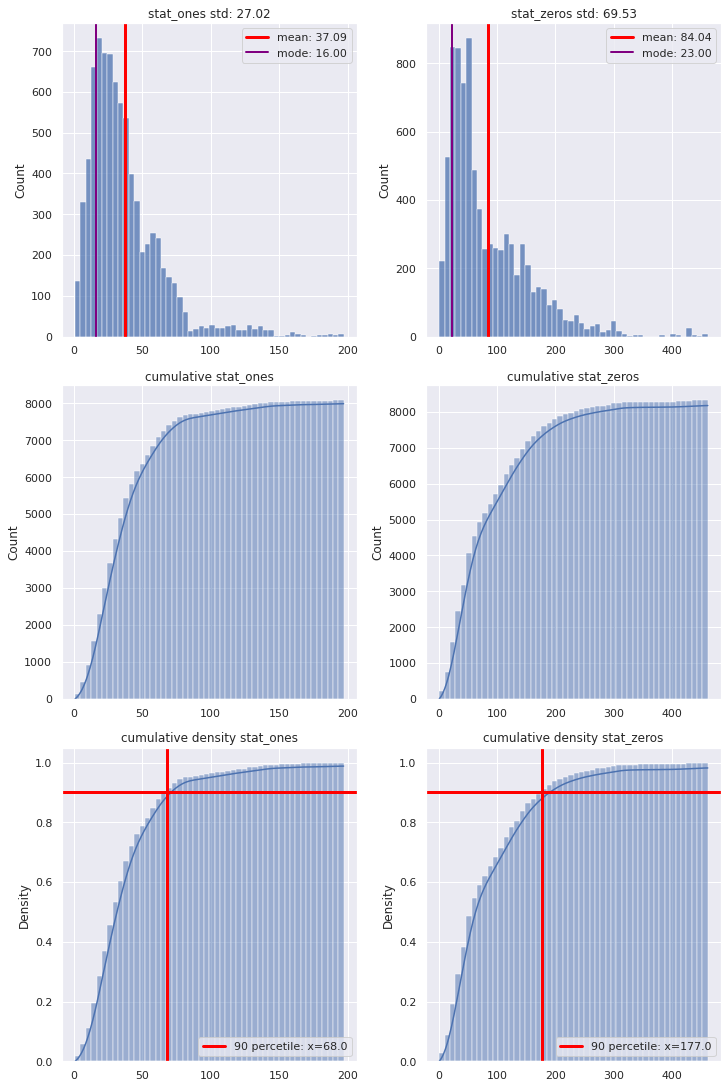

In [12]:
compare_stats(stats=[stat_ones, stat_zeros], names_of_stats=["stat_ones", "stat_zeros"], num_bins=50)

# Several phantoms

In [13]:
shape = [1000, 1000]
blobnses = [1, 3, 6]
porosity = 0.3
phantoms = [generator.blobs(shape, porosity= 1 - porosity, blobiness=b) for b in blobnses]

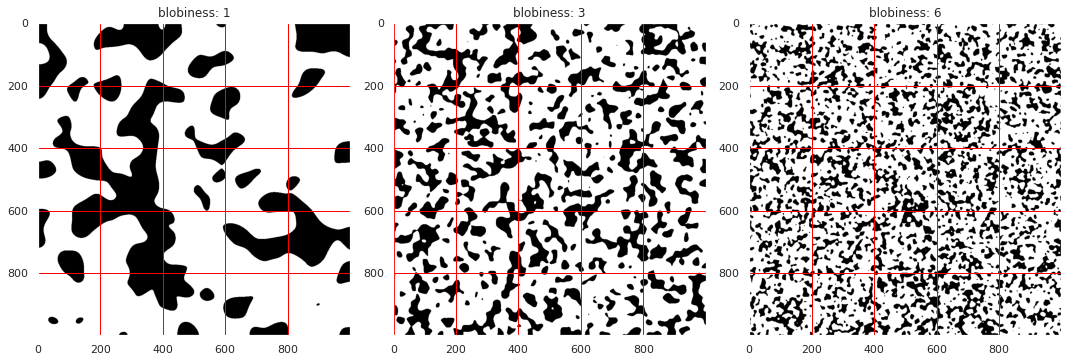

In [14]:
fig, axes = plt.subplots(ncols=3, figsize=(15,5))

for ax, blobns, phantom in zip(axes, blobnses, phantoms):
    ax.imshow(phantom, cmap='gray')
    ax.set_title(f"blobiness: {blobns}")
    ax.grid(color='red')

plt.tight_layout()

Text(0.5, 0.98, 'statistics for PORE-lengths; axis=Both')

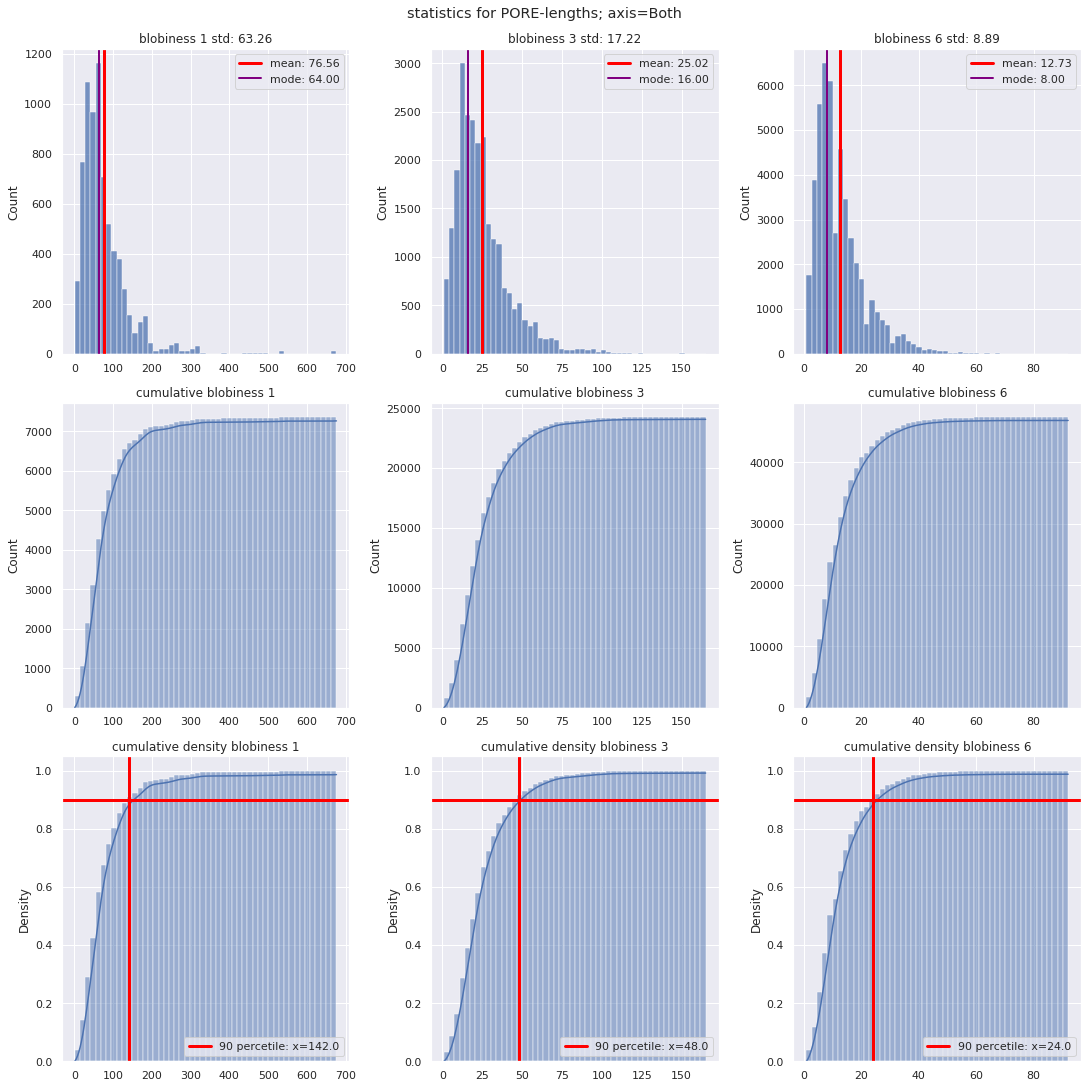

In [15]:
axis = "Both"
stats_zeros = [get_stats(phantom, row_numbers, axis=axis)[0] for phantom in phantoms]
fig = compare_stats(stats=stats_zeros, names_of_stats=[f"blobiness {b}" for b in blobnses], num_bins=50)
fig.suptitle(f"statistics for PORE-lengths; axis={axis}")


Text(0.5, 0.98, 'statistics for MATERIAL-lengths')

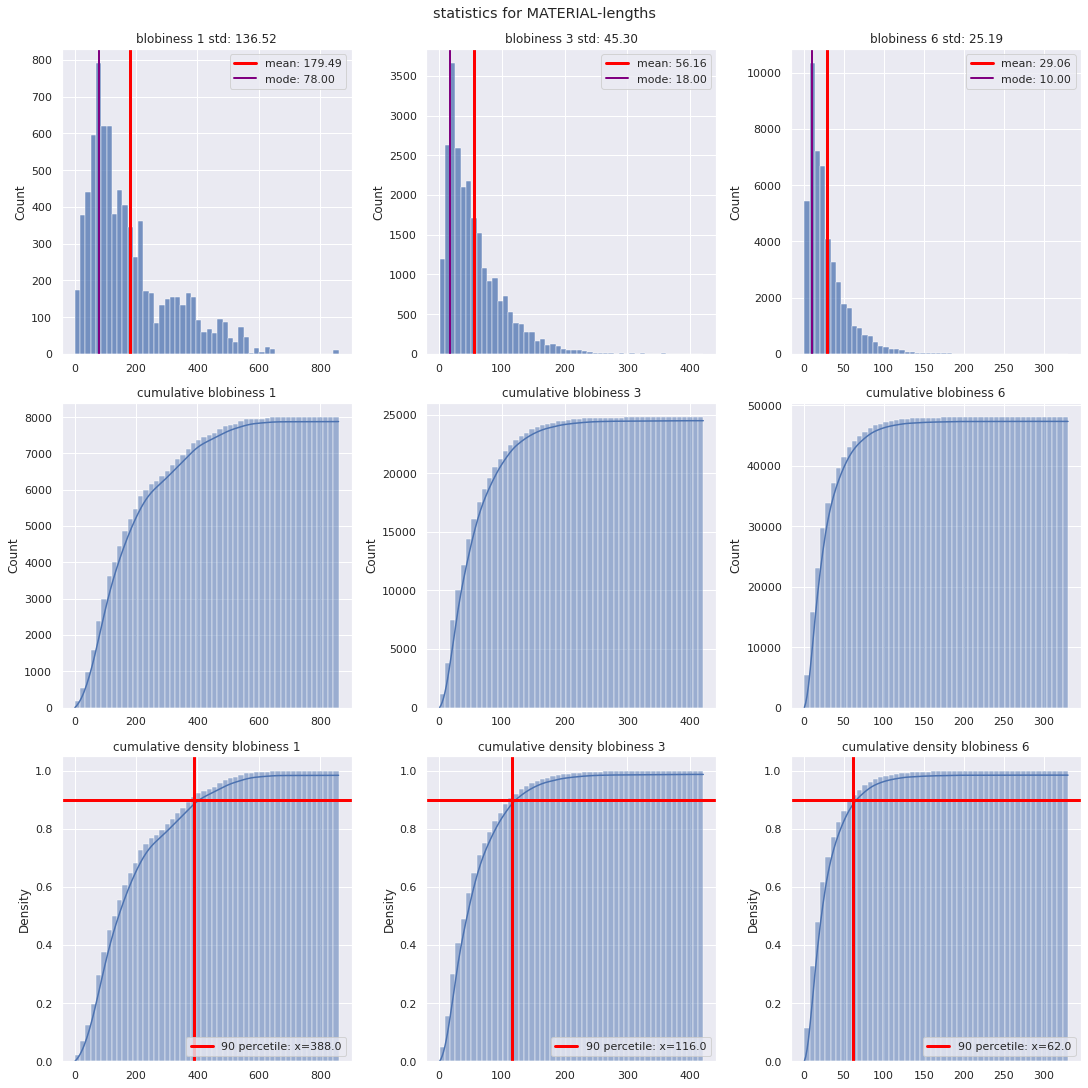

In [16]:
stats_zeros = [get_stats(phantom, row_numbers, axis=axis)[1] for phantom in phantoms]
fig = compare_stats(stats=stats_zeros, names_of_stats=[f"blobiness {b}" for b in blobnses], num_bins=50)
fig.suptitle("statistics for MATERIAL-lengths")

# Own phantoms

In [17]:
import scipy.ndimage as spim
from porespy.tools import norm_to_uniform

In [18]:
def gen_phantom(shape, porosity, blobiness):
    shape = np.array(shape)
    if np.size(shape) == 1:
        shape = np.full((3, ), int(shape))
    im = np.random.random(shape)
    im = spim.gaussian_filter(im, sigma=blobiness)
    im = norm_to_uniform(im, scale=[0, 1])
    if porosity:
        im = im < porosity
    return im

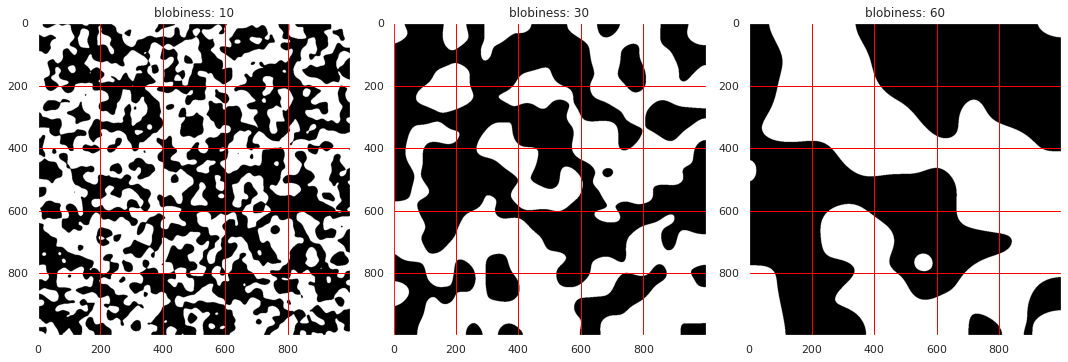

In [19]:
shape = [1000, 1000]
blobnses = [10, 30, 60]
porosity = 0.5
own_phantoms = [gen_phantom(shape, porosity= 1 - porosity, blobiness=b) for b in blobnses]

fig, axes = plt.subplots(ncols=3, figsize=(15,5))

for ax, blobns, own_phantom in zip(axes, blobnses, own_phantoms):
    ax.imshow(own_phantom, cmap='gray')
    ax.set_title(f"blobiness: {blobns}")
    ax.grid(color='red')

plt.tight_layout()

Text(0.5, 0.98, 'statistics for PORE-lengths; axis=Both')

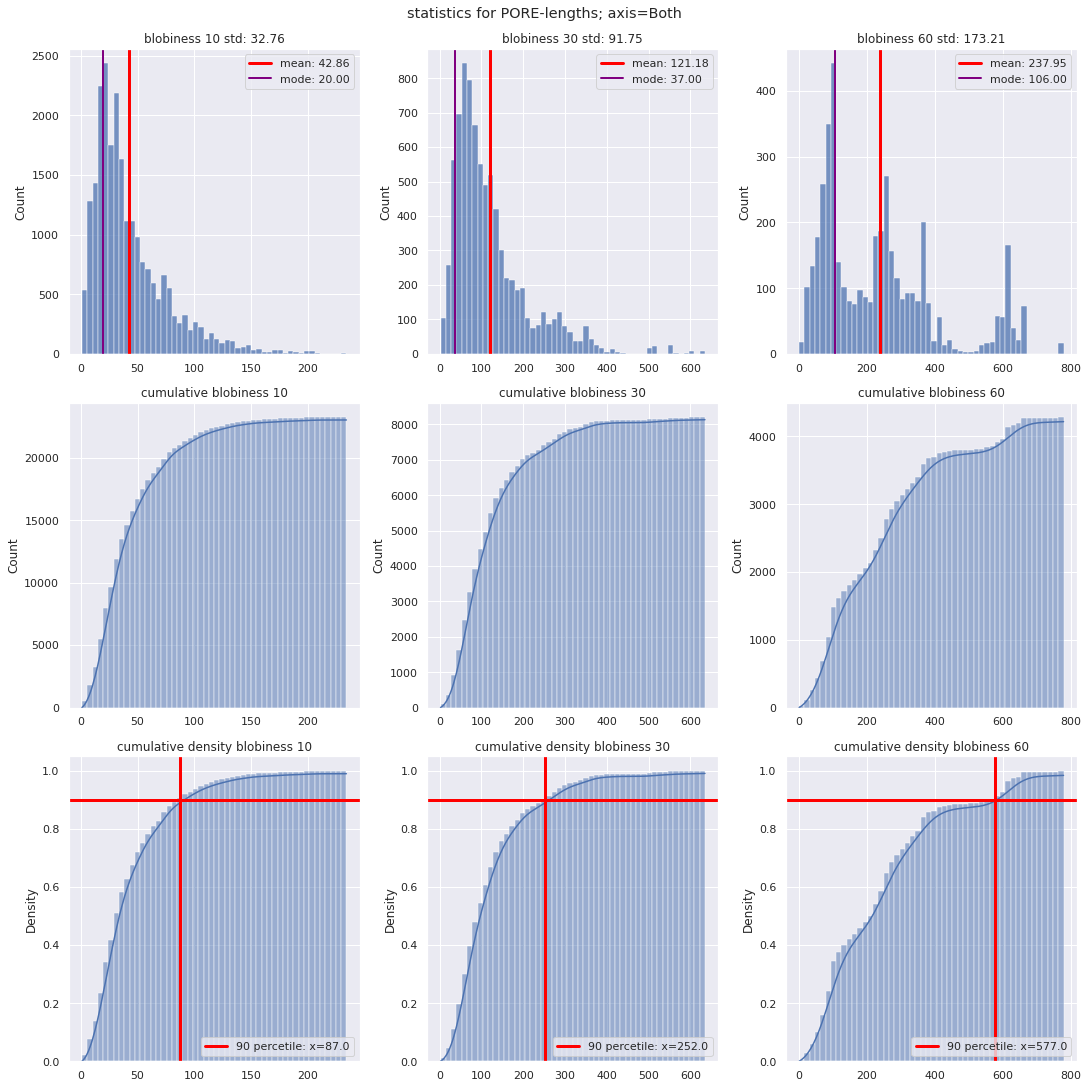

In [20]:
axis = "Both"
stats_zeros = [get_stats(own_phantom, row_numbers, axis=axis)[0] for own_phantom in own_phantoms]
fig = compare_stats(stats=stats_zeros, names_of_stats=[f"blobiness {b}" for b in blobnses], num_bins=50)
fig.suptitle(f"statistics for PORE-lengths; axis={axis}")


# Trial to find dependecies

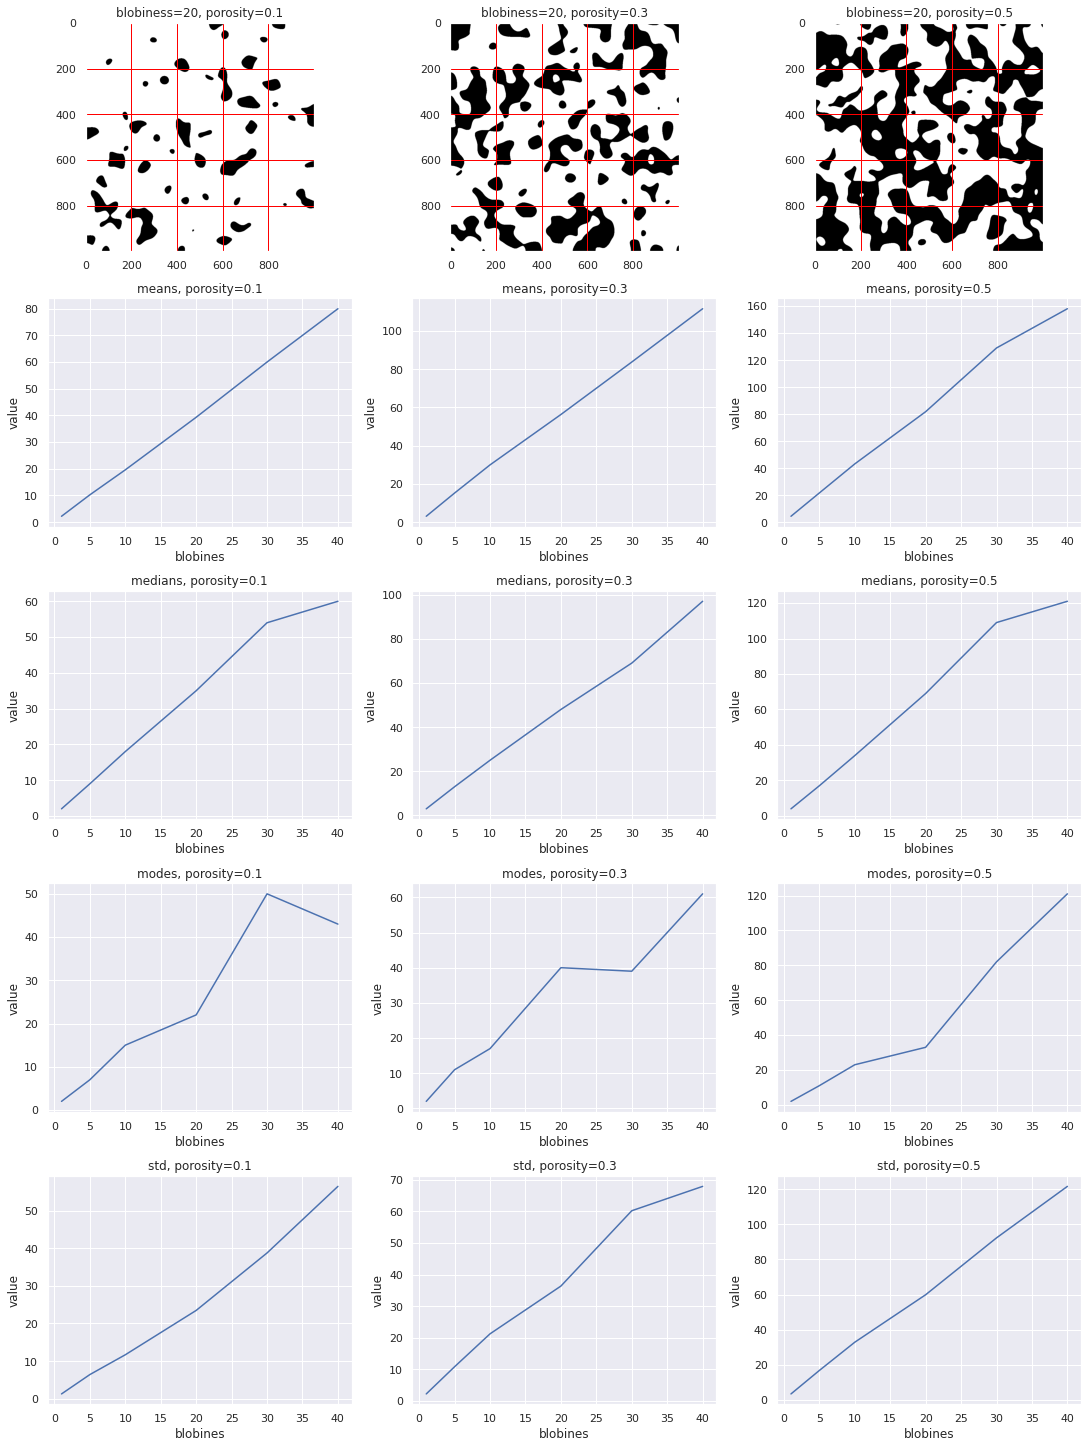

In [91]:
blobnses = [1, 5, 10, 20, 30, 40]
porosities = [0.1, 0.3, 0.5]
shape = [1000, 1000]
axis = "Both"

fig, axes = plt.subplots(ncols=len(porosities), nrows=5, figsize=(15, 20), constrained_layout=True)
for ax in axes.flatten()[3:]:
    ax.set(xlabel='blobines', ylabel='value')
axes = np.transpose(axes)

for porosity, axes_col in zip(porosities, axes):
    own_phantoms = [gen_phantom(shape, porosity= 1 - porosity, blobiness=b) for b in blobnses]
    middle_index = len(blobnses)//2
    axes_col[0].imshow(own_phantoms[middle_index], cmap="gray")
    axes_col[0].set_title(f"blobiness={blobnses[middle_index]}, porosity={porosity}")
    axes_col[0].grid(color='red')

    stats_zeros = [get_stats(own_phantom, row_numbers, axis=axis)[0] for own_phantom in own_phantoms]

    means, modes, st_devs, medians= [], [], [], []
    for stat_zeros in stats_zeros:
        means.append(np.mean(stat_zeros))
        medians.append(np.median(stat_zeros))
        modes.append(int(mode(stat_zeros)[0]))
        st_devs.append(np.std(stat_zeros))

    sns.lineplot(x=blobnses, y=means, markers=True, ax=axes_col[1]).set_title(f"means, porosity={porosity}")
    sns.lineplot(x=blobnses, y=medians, markers=True, ax=axes_col[2]).set_title(f"medians, porosity={porosity}")
    sns.lineplot(x=blobnses, y=modes, markers=True, ax=axes_col[3]).set_title(f"modes, porosity={porosity}")
    sns.lineplot(x=blobnses, y=st_devs, markers=True, ax=axes_col[4]).set_title(f"std, porosity={porosity}")

In [118]:
blobnses = [1, 5, 10, 20, 30] #[1, 5, 10, 20, 30, 40, 60]
porosities = [0.1, 0.3, 0.5]
shape = [1000, 1000]
sampling = 10
axis = "Both"
df = pd.DataFrame(columns = ['porosity', 'blobns', 'hist_mean'])

for _ in range(sampling):
    for porosity in porosities:
        for blobns in blobnses:
            phantom = gen_phantom(shape, porosity= 1 - porosity, blobiness=blobns)
            hist_mean = np.mean(get_stats(phantom, row_numbers, axis=axis)[0])
            df = df.append({'porosity': porosity, 'blobns': blobns, 'hist_mean': hist_mean}, ignore_index=True)


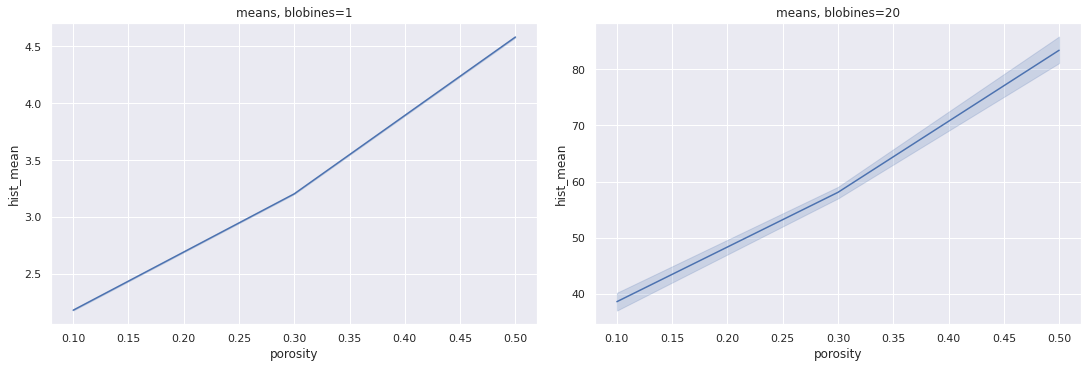

In [119]:
sample_blobns = blobnses[::3]
fig, axes = plt.subplots(ncols=len(sample_blobns), figsize=(15, 5), constrained_layout=True)
for ax, b in zip(axes, sample_blobns):
    sns.lineplot(data=df[df["blobns"]==b], x="porosity", y="hist_mean", ax=ax).set_title(f"means, blobines={b}")

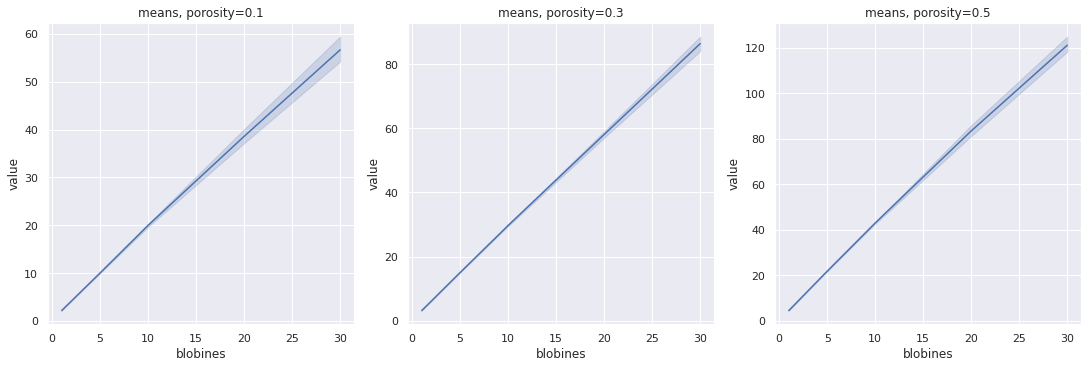

In [120]:
fig, axes = plt.subplots(ncols=len(porosities), figsize=(15, 5), constrained_layout=True)
for ax, p in zip(axes, porosities):
    ax.set(xlabel='blobines', ylabel='value')
    sns.lineplot(data=df[df["porosity"]==p], x="blobns", y="hist_mean", ax=ax).set_title(f"means, porosity={p}")

# Regression without mean

In [121]:
porosities = np.unique(df["porosity"])
porosities

array([0.1, 0.3, 0.5])

In [122]:
blobinesses = np.unique(df["blobns"]).astype(int)
blobinesses

array([ 1,  5, 10, 20, 30])

In [123]:
meshgrid = np.array(np.meshgrid(porosities, blobinesses)).T
diabetes_X_train = meshgrid.reshape(-1, meshgrid.shape[-1])

In [124]:
train_data = []
for p, b in diabetes_X_train:
    diabetes_Y_train = df.loc[(df["porosity"]==p) & (df["blobns"]==b)]["hist_mean"].to_numpy()
    train_data += [[p, int(b), hist_mean] for hist_mean in diabetes_Y_train]
train_data = np.asarray(train_data).T

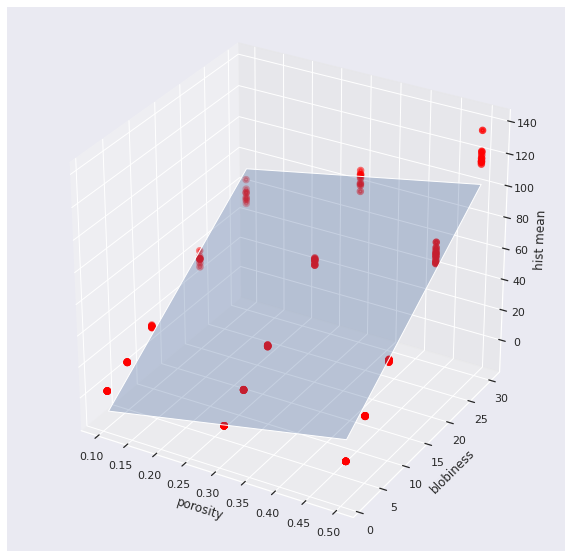

In [125]:


porosity_min, blobiness_min = np.min(train_data[0]), np.min(train_data[1])
porosity_max, blobiness_max = np.max(train_data[0]), np.max(train_data[1])

p, b = np.meshgrid([porosity_min, porosity_max], [blobiness_min, blobiness_max])

regr = linear_model.LinearRegression()
regr.fit(train_data[0:-1].T, train_data[-1])

hist_mean = regr.intercept_ + p*regr.coef_[0] + b*regr.coef_[1]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('porosity')
ax.set_ylabel('blobiness')
ax.set_zlabel('hist mean')

ax.plot_surface(p, b, hist_mean, alpha=0.3)
ax.scatter(*train_data[0:-1], train_data[-1], color='red', linewidth=3)

plt.show()

# Tests

In [126]:
find_blobiness = lambda porosity, hist_mean: (hist_mean - regr.intercept_ - porosity*regr.coef_[0]) / regr.coef_[1]

(-0.5, 999.5, 999.5, -0.5)

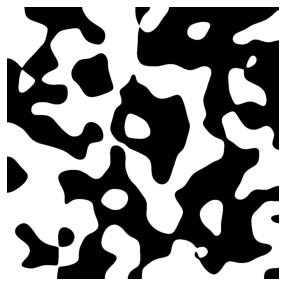

In [127]:
fig, ax = plt.subplots(nrows=1, figsize=(5,5))

shape = [1000, 1000]
porosity = 0.5
blobns = 30
phantom = gen_phantom(shape, porosity= 1 - porosity, blobiness=blobns)
ax.imshow(phantom, cmap='gray')
ax.axis("off")

In [128]:
stat_zeros = get_stats(phantom, row_numbers, axis=axis)[0]
hist_mean = np.mean(stat_zeros)
find_blobiness(porosity, hist_mean)

33.783716512437664

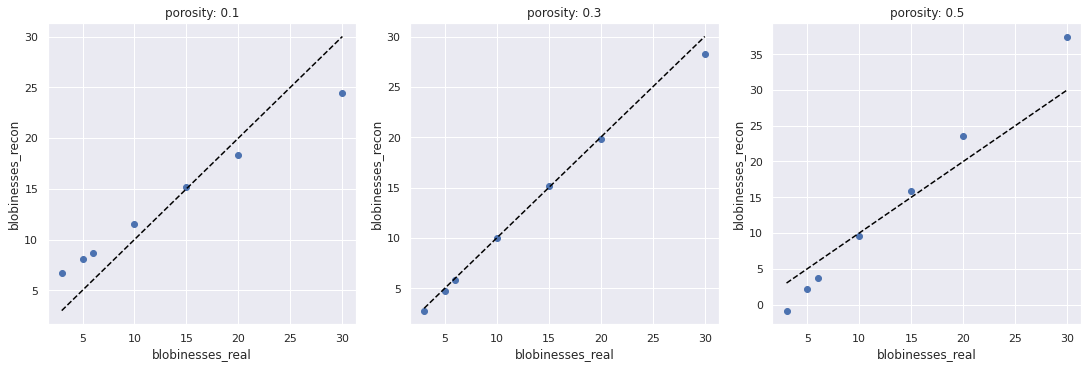

In [129]:
porosities = [0.1, 0.3, 0.5]
blobinesses_real = [3, 5, 6, 10, 15, 20, 30]

fig, axes = plt.subplots(ncols=len(porosities), figsize=(15, 5), constrained_layout=True)


for porosity, ax in zip(porosities, axes):
    blobinesses_recon = []
    for blobns_real in blobinesses_real:
        phantom = gen_phantom(shape, porosity= 1 - porosity, blobiness=blobns_real)
        hist_mean = np.mean(get_stats(phantom, row_numbers, axis=axis)[0])
        blobinesses_recon.append(find_blobiness(porosity, hist_mean))
    ax.scatter(x=blobinesses_real, y=blobinesses_recon)
    ax.plot([np.min(blobinesses_real), np.max(blobinesses_real)], 
            [np.min(blobinesses_real), np.max(blobinesses_real)],
            linestyle="dashed",
            color="black")
    ax.set_xlabel("blobinesses_real")
    ax.set_ylabel("blobinesses_recon")
    ax.set_title(f"porosity: {porosity}")